In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [75]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'n_iter', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_n_iter', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [76]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [77]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


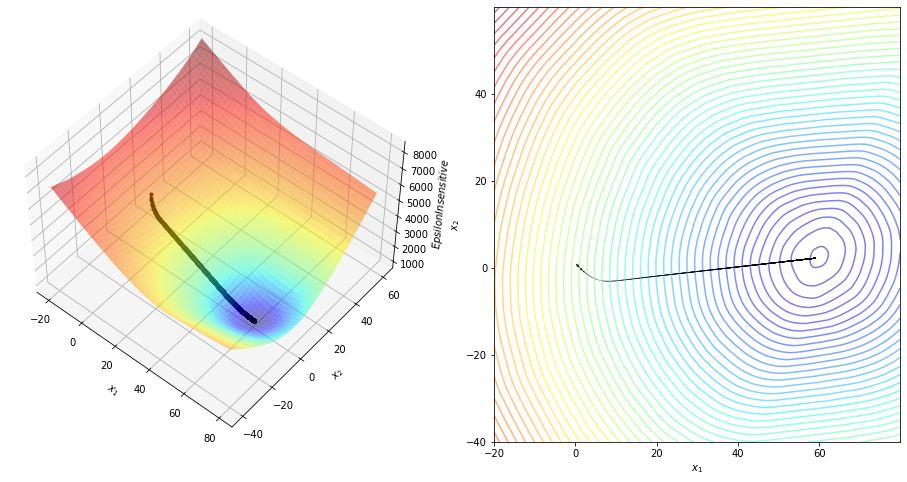

In [78]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1, 
                              max_iter=4000, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [79]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver  C   epsilon                                                     
adagrad 1   0.1      0.500903     874  0.919199  0.915667          66   
            0.2      0.520920     899  0.919989  0.916501          66   
            0.3      0.492739     892  0.920106  0.916682          65   
        10  0.1      1.908153    3563  0.977825  0.972897          65   
            0.2      1.928568    3511  0.977798  0.972835          65   
            0.3      1.966859    3472  0.977782  0.972878          65   
        100 0.1      2.192868    4000  0.978121  0.974183          66   
            0.2      2.188309    4000  0.978122  0.974181          66   
            0.3      1.773110    4000  0.978114  0.974238          66   

                     val_n_sv  
solver  C   epsilon            
adagrad 1   0.1            33  
            0.2            33  
            0.3            33  
        10  0.1            32  
            0.2            32  
            0.3            32  
        100 0.1            32  
            0.2            32  
            0.3            32

In [80]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [81]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
liblinear 1   0.1      0.000638      11  0.918857  0.916865          66   
              0.2      0.000524      10  0.918776  0.916636          65   
              0.3      0.000628      11  0.919178  0.916947          64   
          10  0.1      0.000586     112  0.977849  0.972088          65   
              0.2      0.000770     241  0.977851  0.972025          64   
              0.3      0.000703      79  0.977865  0.972165          64   
          100 0.1      0.000962     691  0.977723  0.974270          66   
              0.2      0.001155     690  0.977642  0.973868          65   
              0.3      0.001333     920  0.977632  0.973861          64   

                       val_n_sv  
solver    C   epsilon            
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

In [82]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='h!')
primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
adagrad   1   0.1      0.500903     874  0.919199  0.915667          66   
              0.2      0.520920     899  0.919989  0.916501          66   
              0.3      0.492739     892  0.920106  0.916682          65   
          10  0.1      1.908153    3563  0.977825  0.972897          65   
              0.2      1.928568    3511  0.977798  0.972835          65   
              0.3      1.966859    3472  0.977782  0.972878          65   
          100 0.1      2.192868    4000  0.978121  0.974183          66   
              0.2      2.188309    4000  0.978122  0.974181          66   
              0.3      1.773110    4000  0.978114  0.974238          66   
liblinear 1   0.1      0.000638      11  0.918857  0.916865          66   
              0.2      0.000524      10  0.918776  0.916636          65   
              0.3      0.000628      11  0.919178  0.916947          64   
          10  0.1      0.000586     112  0.977849  0.972088          65   
              0.2      0.000770     241  0.977851  0.972025          64   
              0.3      0.000703      79  0.977865  0.972165          64   
          100 0.1      0.000962     691  0.977723  0.974270          66   
              0.2      0.001155     690  0.977642  0.973868          65   
              0.3      0.001333     920  0.977632  0.973861          64   

                       val_n_sv  
solver    C   epsilon            
adagrad   1   0.1            33  
              0.2            33  
              0.3            33  
          10  0.1            32  
              0.2            32  
              0.3            32  
          100 0.1            32  
              0.2            32  
              0.3            32  
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

### Dual formulations

In [83]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [84]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [109]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1, 
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


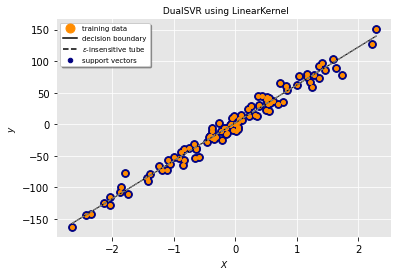

In [86]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [87]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                           
cvxopt 1   0.1      0.022606      -  0.917772  0.914479          67        67
           0.2      0.017384      -  0.918341  0.915058          67        67
           0.3      0.019242      -  0.918942  0.915614          66        66
       10  0.1      0.011362      -  0.977920  0.972466          67        67
           0.2      0.012415      -  0.977926  0.972474          67        67
           0.3      0.011413      -  0.977954  0.972562          66        66
       100 0.1      0.013810      -  0.977788  0.974150          67        67
           0.2      0.009693      -  0.977742  0.974033          67        67
           0.3      0.010091      -  0.977737  0.973956          67        67
smo    1   0.1      0.017907     15  0.917773  0.914442          66        66
           0.2      0.017952     13  0.918341  0.915019          66        66
           0.3      0.034489     60  0.918942  0.915576          66        66
       10  0.1      0.060913     56  0.977920  0.972445          66        66
           0.2      0.128869    219  0.977926  0.972457          65        65
           0.3      0.064198     38  0.977953  0.972544          65        65
       100 0.1      0.508378   1508  0.977788  0.974139          66        66
           0.2      0.279826    394  0.977742  0.974022          66        66
           0.3      0.432186    900  0.977737  0.973939          66        66

In [88]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [89]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.004814      63  0.917627  0.915448          66        66
           0.2      0.004183     102  0.918194  0.915985          66        66
           0.3      0.001977      54  0.918786  0.916554          66        66
       10  0.1      0.001908     282  0.977852  0.972051          66        66
           0.2      0.001831     193  0.977851  0.972025          65        65
           0.3      0.002594     593  0.977870  0.972135          65        65
       100 0.1      0.003477    2621  0.977723  0.974270          66        66
           0.2      0.003964    2709  0.977673  0.974122          66        66
           0.3      0.004462    4141  0.977655  0.974045          66        66

In [90]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='h!')
linear_dual_svr_cv_results

fit_time n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                           
cvxopt 1   0.1      0.022606      -  0.917772  0.914479          67        67
           0.2      0.017384      -  0.918341  0.915058          67        67
           0.3      0.019242      -  0.918942  0.915614          66        66
       10  0.1      0.011362      -  0.977920  0.972466          67        67
           0.2      0.012415      -  0.977926  0.972474          67        67
           0.3      0.011413      -  0.977954  0.972562          66        66
       100 0.1      0.013810      -  0.977788  0.974150          67        67
           0.2      0.009693      -  0.977742  0.974033          67        67
           0.3      0.010091      -  0.977737  0.973956          67        67
smo    1   0.1      0.017907     15  0.917773  0.914442          66        66
           0.2      0.017952     13  0.918341  0.915019          66        66
           0.3      0.034489     60  0.918942  0.915576          66        66
       10  0.1      0.060913     56  0.977920  0.972445          66        66
           0.2      0.128869    219  0.977926  0.972457          65        65
           0.3      0.064198     38  0.977953  0.972544          65        65
       100 0.1      0.508378   1508  0.977788  0.974139          66        66
           0.2      0.279826    394  0.977742  0.974022          66        66
           0.3      0.432186    900  0.977737  0.973939          66        66
libsvm 1   0.1      0.004814     63  0.917627  0.915448          66        66
           0.2      0.004183    102  0.918194  0.915985          66        66
           0.3      0.001977     54  0.918786  0.916554          66        66
       10  0.1      0.001908    282  0.977852  0.972051          66        66
           0.2      0.001831    193  0.977851  0.972025          65        65
           0.3      0.002594    593  0.977870  0.972135          65        65
       100 0.1      0.003477   2621  0.977723  0.974270          66        66
           0.2      0.003964   2709  0.977673  0.974122          66        66
           0.3      0.004462   4141  0.977655  0.974045          66        66

##### Nonlinear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


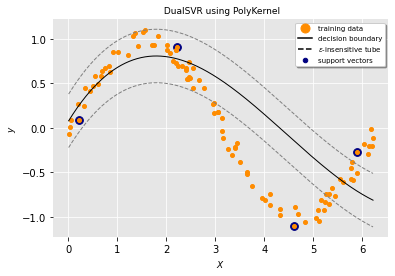

In [57]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [59]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time   train_r2     val_r2   n_iter  \
solver kernel C   epsilon                                               
cvxopt poly   1   0.1         0.041113   0.905433 -15.210301        1   
                  0.2         0.020089 -24.954851  -9.710897        1   
                  0.3         0.011838  -0.215852  -7.639445        1   
              10  0.1         0.010001   0.811604 -10.451673        1   
                  0.2         0.013686  -2.558647  -8.951845        1   
                  0.3         0.015321   0.445454  -7.324711        1   
              100 0.1         0.010776   0.897682 -11.713805        1   
                  0.2         0.013330  -2.558605  -8.951984        1   
                  0.3         0.015465   0.445417  -7.324471        1   
smo    poly   1   0.1        48.441721   0.851002 -13.573915    63892   
                  0.2         2.087687 -24.226843 -17.509435     2656   
                  0.3         1.013869  -1.075241 -13.457557     1340   
              10  0.1       321.763062   0.829192 -10.919496   638453   
                  0.2         3.081885  -1.965039 -16.772837     3985   
                  0.3         2.166342  -0.416636 -13.148526     2726   
              100 0.1      2375.492913   0.888191 -12.849364  5679480   
                  0.2         3.046712  -1.965039 -16.772837     3985   
                  0.3         2.011438  -0.416636 -13.148526     2726   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              30        30  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              31        31  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              51        51  
                  0.2               4         4  
                  0.3               3         3  
smo    poly   1   0.1              28        28  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              28        28  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              28        28  
                  0.2               4         4  
                  0.3               3         3

Fitting 3 folds for each of 18 candidates, totalling 54 fits


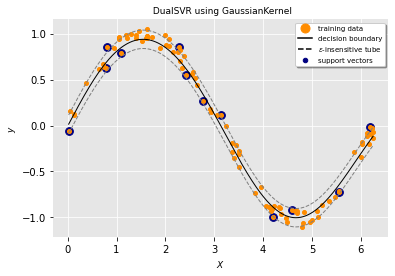

In [92]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [93]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time n_iter  train_r2    val_r2  train_n_sv  \
solver kernel C   epsilon                                                    
cvxopt rbf    1   0.1      0.014610      -  0.983128  0.472774          12   
                  0.2      0.011270      -  0.965921 -0.685438           7   
                  0.3      0.012746      -  0.886375 -1.866503           5   
              10  0.1      0.010773      -  0.987400  0.814540           9   
                  0.2      0.011876      -  0.964815 -0.687669           6   
                  0.3      0.011370      -  0.874593 -2.001040           4   
              100 0.1      0.010134      -  0.981179  0.854367           9   
                  0.2      0.011038      -  0.962024 -0.630939           6   
                  0.3      0.011310      -  0.893251 -0.801456           5   
smo    rbf    1   0.1      0.042733     35  0.977543  0.447446          10   
                  0.2      0.018814     18  0.961709 -0.706292           6   
                  0.3      0.016197     18  0.877846 -2.174799           5   
              10  0.1      0.145227    168  0.984622  0.831171           8   
                  0.2      0.019114     22  0.960406 -0.708836           6   
                  0.3      0.012624     16  0.846434 -2.206505           4   
              100 0.1      0.161255    223  0.982501  0.835906           8   
                  0.2      0.016944     22  0.960406 -0.708836           6   
                  0.3      0.011717     16  0.846434 -2.206505           4   

                           val_n_sv  
solver kernel C   epsilon            
cvxopt rbf    1   0.1            12  
                  0.2             7  
                  0.3             5  
              10  0.1             9  
                  0.2             6  
                  0.3             4  
              100 0.1             9  
                  0.2             6  
                  0.3             5  
smo    rbf    1   0.1            10  
                  0.2             6  
                  0.3             5  
              10  0.1             8  
                  0.2             6  
                  0.3             4  
              100 0.1             8  
                  0.2             6  
                  0.3             4

In [94]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time   train_r2     val_r2   n_iter  \
solver kernel C   epsilon                                               
cvxopt poly   1   0.1         0.041113   0.905433 -15.210301        1   
                  0.2         0.020089 -24.954851  -9.710897        1   
                  0.3         0.011838  -0.215852  -7.639445        1   
              10  0.1         0.010001   0.811604 -10.451673        1   
                  0.2         0.013686  -2.558647  -8.951845        1   
                  0.3         0.015321   0.445454  -7.324711        1   
              100 0.1         0.010776   0.897682 -11.713805        1   
                  0.2         0.013330  -2.558605  -8.951984        1   
                  0.3         0.015465   0.445417  -7.324471        1   
       rbf    1   0.1         0.014610   0.983128   0.472774        -   
                  0.2         0.011270   0.965921  -0.685438        -   
                  0.3         0.012746   0.886375  -1.866503        -   
              10  0.1         0.010773   0.987400   0.814540        -   
                  0.2         0.011876   0.964815  -0.687669        -   
                  0.3         0.011370   0.874593  -2.001040        -   
              100 0.1         0.010134   0.981179   0.854367        -   
                  0.2         0.011038   0.962024  -0.630939        -   
                  0.3         0.011310   0.893251  -0.801456        -   
smo    poly   1   0.1        48.441721   0.851002 -13.573915    63892   
                  0.2         2.087687 -24.226843 -17.509435     2656   
                  0.3         1.013869  -1.075241 -13.457557     1340   
              10  0.1       321.763062   0.829192 -10.919496   638453   
                  0.2         3.081885  -1.965039 -16.772837     3985   
                  0.3         2.166342  -0.416636 -13.148526     2726   
              100 0.1      2375.492913   0.888191 -12.849364  5679480   
                  0.2         3.046712  -1.965039 -16.772837     3985   
                  0.3         2.011438  -0.416636 -13.148526     2726   
       rbf    1   0.1         0.042733   0.977543   0.447446       35   
                  0.2         0.018814   0.961709  -0.706292       18   
                  0.3         0.016197   0.877846  -2.174799       18   
              10  0.1         0.145227   0.984622   0.831171      168   
                  0.2         0.019114   0.960406  -0.708836       22   
                  0.3         0.012624   0.846434  -2.206505       16   
              100 0.1         0.161255   0.982501   0.835906      223   
                  0.2         0.016944   0.960406  -0.708836       22   
                  0.3         0.011717   0.846434  -2.206505       16   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              30        30  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              31        31  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              51        51  
                  0.2               4         4  
                  0.3               3         3  
       rbf    1   0.1              12        12  
                  0.2               7         7  
                  0.3               5         5  
              10  0.1               9         9  
                  0.2               6         6  
                  0.3               4         4  
              100 0.1               9         9  
                  0.2               6         6  
                  0.3               5         5  
smo    poly   1   0.1              28        28  
                  0.2               6         6  
                  0.3               4         4  
              10  0.1              28        28  
                  0.2               4         4  
     

In [95]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [96]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time    n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                            
libsvm poly   1   0.1      0.071900    220996  0.978286 -11.848929   
                  0.2      0.008648      5830  0.970950 -10.792492   
                  0.3      0.005080      2957  0.919241 -31.298810   
              10  0.1      0.367158   1149782  0.977816 -12.116107   
                  0.2      0.016228      6665  0.972071 -10.791561   
                  0.3      0.003214      4236  0.921527 -31.296613   
              100 0.1      5.444041  35310042  0.944878  -3.393675   
                  0.2      0.003119      6665  0.972071 -10.791561   
                  0.3      0.022383      4236  0.921527 -31.296613   
       rbf    1   0.1      0.016349        96  0.982884  -0.165508   
                  0.2      0.004455        24  0.966819  -0.342140   
                  0.3      0.007898        11  0.915276  -0.739398   
              10  0.1      0.007063       418  0.983896   0.533980   
                  0.2      0.006231        26  0.967504  -0.342386   
                  0.3      0.001741        11  0.923754  -0.734560   
              100 0.1      0.003601      3500  0.984122   0.710024   
                  0.2      0.008419        26  0.967504  -0.342386   
                  0.3      0.004023        11  0.923754  -0.734560   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
libsvm poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              20        20  
                  0.2               4         4  
                  0.3               4         4  
              100 0.1              28        28  
                  0.2               4         4  
                  0.3               4         4  
       rbf    1   0.1              18        18  
                  0.2               6         6  
                  0.3               5         5  
              10  0.1              18        18  
                  0.2               6         6  
                  0.3               4         4  
              100 0.1              19        19  
                  0.2               6         6  
                  0.3               4         4

In [97]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='h!')
nonlinear_dual_svr_cv_results

fit_time   train_r2     val_r2    n_iter  \
solver kernel C   epsilon                                                
cvxopt poly   1   0.1         0.041113   0.905433 -15.210301         1   
                  0.2         0.020089 -24.954851  -9.710897         1   
                  0.3         0.011838  -0.215852  -7.639445         1   
              10  0.1         0.010001   0.811604 -10.451673         1   
                  0.2         0.013686  -2.558647  -8.951845         1   
                  0.3         0.015321   0.445454  -7.324711         1   
              100 0.1         0.010776   0.897682 -11.713805         1   
                  0.2         0.013330  -2.558605  -8.951984         1   
                  0.3         0.015465   0.445417  -7.324471         1   
       rbf    1   0.1         0.014610   0.983128   0.472774         -   
                  0.2         0.011270   0.965921  -0.685438         -   
                  0.3         0.012746   0.886375  -1.866503         -   
              10  0.1         0.010773   0.987400   0.814540         -   
                  0.2         0.011876   0.964815  -0.687669         -   
                  0.3         0.011370   0.874593  -2.001040         -   
              100 0.1         0.010134   0.981179   0.854367         -   
                  0.2         0.011038   0.962024  -0.630939         -   
                  0.3         0.011310   0.893251  -0.801456         -   
smo    poly   1   0.1        48.441721   0.851002 -13.573915     63892   
                  0.2         2.087687 -24.226843 -17.509435      2656   
                  0.3         1.013869  -1.075241 -13.457557      1340   
              10  0.1       321.763062   0.829192 -10.919496    638453   
                  0.2         3.081885  -1.965039 -16.772837      3985   
                  0.3         2.166342  -0.416636 -13.148526      2726   
              100 0.1      2375.492913   0.888191 -12.849364   5679480   
                  0.2         3.046712  -1.965039 -16.772837      3985   
                  0.3         2.011438  -0.416636 -13.148526      2726   
       rbf    1   0.1         0.042733   0.977543   0.447446        35   
                  0.2         0.018814   0.961709  -0.706292        18   
                  0.3         0.016197   0.877846  -2.174799        18   
              10  0.1         0.145227   0.984622   0.831171       168   
                  0.2         0.019114   0.960406  -0.708836        22   
                  0.3         0.012624   0.846434  -2.206505        16   
              100 0.1         0.161255   0.982501   0.835906       223   
                  0.2         0.016944   0.960406  -0.708836        22   
                  0.3         0.011717   0.846434  -2.206505        16   
libsvm poly   1   0.1         0.071900   0.978286 -11.848929    220996   
                  0.2         0.008648   0.970950 -10.792492      5830   
                  0.3         0.005080   0.919241 -31.298810      2957   
              10  0.1         0.367158   0.977816 -12.116107   1149782   
                  0.2         0.016228   0.972071 -10.791561      6665   
                  0.3         0.003214   0.921527 -31.296613      4236   
              100 0.1         5.444041   0.944878  -3.393675  35310042   
                  0.2         0.003119   0.972071 -10.791561      6665   
                  0.3         0.022383   0.921527 -31.296613      4236   
       rbf    1   0.1         0.016349   0.982884  -0.165508        96   
                  0.2         0.004455   0.966819  -0.342140        24   
                  0.3         0.007898   0.915276  -0.739398        11   
              10  0.1         0.007063   0.983896   0.533980       418   
                  0.2         0.006231   0.967504  -0.342386        26   
                  0.3         0.001741   0.923754  -0.734560        11   
              100 0.1         0.003601   0.984122   0.710024      3500   
                  0.2         0.00

#### Lagrangian Dual

##### Linear

In [98]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [99]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='h!')
linear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
dual C   epsilon                                                            
bcqp 1   0.1      0.625542     522  0.731073  0.721200          67        67
         0.2      0.669351     524  0.731073  0.721199          67        67
         0.3      0.602969     526  0.731073  0.721199          67        67
     10  0.1      0.684658     539  0.733638  0.723925          67        67
         0.2      0.616431     541  0.733638  0.723924          67        67
         0.3      0.680966     543  0.733638  0.723924          67        67
     100 0.1      0.602464     539  0.733638  0.723925          67        67
         0.2      0.578202     541  0.733638  0.723924          67        67
         0.3      0.350057     543  0.733638  0.723924          67        67
qp   1   0.1      0.728676     653  0.876534  0.870926          67        67
         0.2      0.704395     653  0.876534  0.870927          67        67
         0.3      0.736444     653  0.876534  0.870927          67        67
     10  0.1      0.521566     519  0.731825  0.722021          67        67
         0.2      0.627350     524  0.731825  0.722021          67        67
         0.3      0.574445     530  0.731825  0.722020          67        67
     100 0.1      0.534212     519  0.731825  0.722021          67        67
         0.2      0.516878     524  0.731825  0.722021          67        67
         0.3      0.512184     530  0.731825  0.722020          67        67

##### Nonlinear

In [100]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [101]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='h!')
nonlinear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2     val_r2  train_n_sv  \
dual kernel C   epsilon                                                      
bcqp poly   1   0.1      0.015649       5  0.661507 -29.201221          67   
                0.2      0.018789      13  0.646500 -21.100895          67   
                0.3      0.033014      26  0.557231  -4.561293          66   
            10  0.1      0.014946       5  0.661507 -29.201221          67   
                0.2      0.017973      13  0.646500 -21.100895          67   
                0.3      0.031867      26  0.557231  -4.561293          66   
            100 0.1      0.008122       5  0.661507 -29.201221          67   
                0.2      0.017465      13  0.646500 -21.100895          67   
                0.3      0.034423      26  0.557231  -4.561293          66   
     rbf    1   0.1      0.071496      33  0.738289  -6.763338          67   
                0.2      0.360525     214  0.669727  -9.484747          67   
                0.3      0.473029     289  0.633164  -9.574473          67   
            10  0.1      0.064096      33  0.738289  -6.763338          67   
                0.2      0.408532     214  0.669727  -9.484747          67   
                0.3      0.449901     289  0.633164  -9.574473          67   
            100 0.1      0.054531      33  0.738289  -6.763338          67   
                0.2      0.349998     214  0.669727  -9.484747          67   
                0.3      0.394743     289  0.633164  -9.574473          67   
qp   poly   1   0.1      0.485274     337  0.661795 -29.156218          67   
                0.2      0.530947     338  0.652693 -24.981785          67   
                0.3      0.572128     342  0.639591 -24.977720          67   
            10  0.1      0.533451     337  0.661795 -29.156218          67   
                0.2      0.450507     338  0.652693 -24.981785          67   
                0.3      0.441770     342  0.639591 -24.977720          67   
            100 0.1      0.419987     337  0.661795 -29.156218          67   
                0.2      0.440672     338  0.652693 -24.981785          67   
                0.3      0.362904     342  0.639591 -24.977720          67   
     rbf    1   0.1      0.276012     137  0.703625  -7.578603          67   
                0.2      0.979279     456  0.687662  -7.986323          67   
                0.3      0.916051     431  0.657016  -8.151421          67   
            10  0.1      0.124846      48  0.692836  -7.929661          67   
                0.2      0.627865     365  0.716080  -7.015988          67   
                0.3      0.574807     350  0.671924  -7.745214          67   
            100 0.1      0.084589      48  0.692836  -7.929661          67   
                0.2      0.599476     365  0.716080  -7.015988          67   
                0.3      0.432920     350  0.671924  -7.745214          67   

                         val_n_sv  
dual kernel C   epsilon            
bcqp poly   1   0.1            67  
                0.2            67  
                0.3            66  
            10  0.1            67  
                0.2            67  
                0.3            66  
            100 0.1            67  
                0.2            67  
                0.3            66  
     rbf    1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
qp   poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   

## Squared Epsilon-insensitive loss

### Primal formulation

In [102]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [103]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


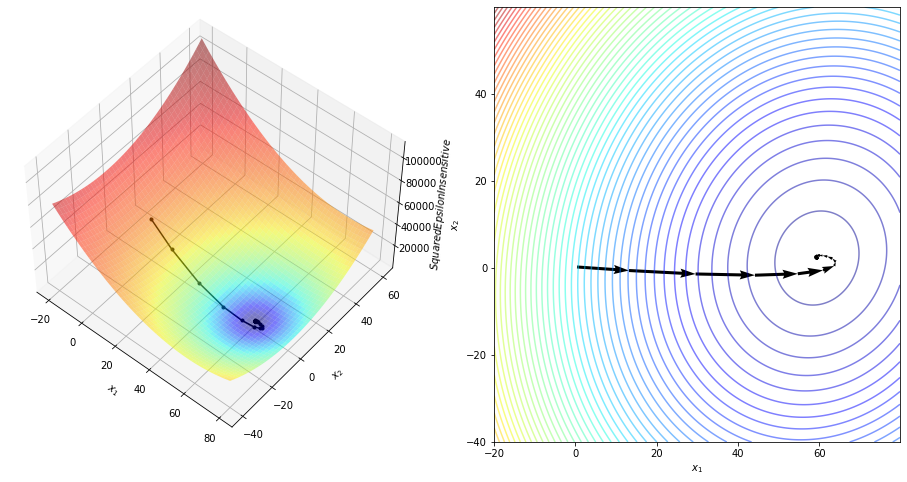

In [104]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [105]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'gd')
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time  n_iter     train_r2       val_r2  \
solver C   momentum epsilon                                               
gd     1   nesterov 0.1      0.120714     183     0.978130     0.973982   
                    0.2      0.098704     181     0.978129     0.973979   
                    0.3      0.108854     179     0.978129     0.973978   
           none     0.1      0.217456     352     0.978126     0.973976   
                    0.2      0.200618     349     0.978125     0.973974   
                    0.3      0.172997     345     0.978124     0.973972   
           standard 0.1      0.126630     180     0.978130     0.973982   
                    0.2      0.112161     177     0.978129     0.973979   
                    0.3      0.094951     176     0.978129     0.973978   
       10  nesterov 0.1      0.014011      26     0.978184     0.973958   
                    0.2      0.013980      25     0.978184     0.973958   
                    0.3      0.011135      25     0.978184     0.973958   
           none     0.1      0.025574      48     0.978184     0.973958   
                    0.2      0.024828      46     0.978184     0.973957   
                    0.3      0.024074      45     0.978183     0.973955   
           standard 0.1      0.013464      25     0.977876     0.975097   
                    0.2      0.013465      25     0.977868     0.975106   
                    0.3      0.013375      25     0.977876     0.975092   
       100 nesterov 0.1      0.003692       6 -1638.307583 -1608.863197   
                    0.2      0.003719       6 -1622.486618 -1592.867828   
                    0.3      0.002775       6 -1651.292447 -1620.647103   
           none     0.1      0.003545       6   -19.106771   -18.943994   
                    0.2      0.003577       6   -18.905404   -18.746050   
                    0.3      0.003799       6   -18.834177   -18.679996   
           standard 0.1      0.018089      29     0.978184     0.973963   
                    0.2      0.016128      29     0.978184     0.973963   
                    0.3      0.013552      29     0.978184     0.973968   

                             train_n_sv  val_n_sv  
solver C   momentum epsilon                        
gd     1   nesterov 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           none     0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           standard 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
       10  nesterov 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33  
           none     0.1              66        33  
                    0.2              66        33  
                    0.3              66        33  
           standard 0.1              65        33  
                    0.2              65        33  
                    0.3              65        33  
       100 nesterov 0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           none     0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           standard 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33

In [106]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [107]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.000897      86  0.978134  0.974000   
                       0.2      0.000700      83  0.978132  0.974006   
                       0.3      0.000768      89  0.978130  0.974014   
          10  -        0.1      0.002579     768  0.978183  0.973965   
                       0.2      0.002345     757  0.978183  0.973979   
                       0.3      0.002486     752  0.978183  0.973977   
          100 -        0.1      0.003818    1000  0.978079  0.972999   
                       0.2      0.003834    1000  0.977766  0.971757   
                       0.3      0.003442    1000  0.978113  0.974832   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              67        32  
                       0.2              66        32  
                       0.3              66        32  
          10  -        0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
          100 -        0.1              66        33  
                       0.2              66        32  
                       0.3              66        32

In [108]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='h!')
primal_svr_squared_eps_cv_results

fit_time  n_iter     train_r2       val_r2  \
solver    C   momentum epsilon                                               
gd        1   nesterov 0.1      0.120714     183     0.978130     0.973982   
                       0.2      0.098704     181     0.978129     0.973979   
                       0.3      0.108854     179     0.978129     0.973978   
              none     0.1      0.217456     352     0.978126     0.973976   
                       0.2      0.200618     349     0.978125     0.973974   
                       0.3      0.172997     345     0.978124     0.973972   
              standard 0.1      0.126630     180     0.978130     0.973982   
                       0.2      0.112161     177     0.978129     0.973979   
                       0.3      0.094951     176     0.978129     0.973978   
          10  nesterov 0.1      0.014011      26     0.978184     0.973958   
                       0.2      0.013980      25     0.978184     0.973958   
                       0.3      0.011135      25     0.978184     0.973958   
              none     0.1      0.025574      48     0.978184     0.973958   
                       0.2      0.024828      46     0.978184     0.973957   
                       0.3      0.024074      45     0.978183     0.973955   
              standard 0.1      0.013464      25     0.977876     0.975097   
                       0.2      0.013465      25     0.977868     0.975106   
                       0.3      0.013375      25     0.977876     0.975092   
          100 nesterov 0.1      0.003692       6 -1638.307583 -1608.863197   
                       0.2      0.003719       6 -1622.486618 -1592.867828   
                       0.3      0.002775       6 -1651.292447 -1620.647103   
              none     0.1      0.003545       6   -19.106771   -18.943994   
                       0.2      0.003577       6   -18.905404   -18.746050   
                       0.3      0.003799       6   -18.834177   -18.679996   
              standard 0.1      0.018089      29     0.978184     0.973963   
                       0.2      0.016128      29     0.978184     0.973963   
                       0.3      0.013552      29     0.978184     0.973968   
liblinear 1   -        0.1      0.000897      86     0.978134     0.974000   
                       0.2      0.000700      83     0.978132     0.974006   
                       0.3      0.000768      89     0.978130     0.974014   
          10  -        0.1      0.002579     768     0.978183     0.973965   
                       0.2      0.002345     757     0.978183     0.973979   
                       0.3      0.002486     752     0.978183     0.973977   
          100 -        0.1      0.003818    1000     0.978079     0.972999   
                       0.2      0.003834    1000     0.977766     0.971757   
                       0.3      0.003442    1000     0.978113     0.974832   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
gd        1   nesterov 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              none     0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              standard 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
          10  nesterov 0.1              66        33  
                       0.2              66        33  
                       0.3              66        33  
              none     0.1              66        33  
                       0.2              66        33  
                       0.3              66        33  
              standard 0.1              65        33  
                       0.2              65        33  
                      